## In the following project, I will compare two trading strategies' performances against a benchmark(SPY ETF) to see how well our strategies perform.

In [1]:
# Import necessary packages
import datetime 
import os.path 
import sys  
import backtrader as bt 
import yfinance as yf 
import numpy as np
import pandas as pd
import ta
from math import floor
from termcolor import colored as cl
import requests
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

# Strategy #1: Bollinger Bands

### Why we need this strategy:

Many traders believe they need more indicators to be a consistently profitable trader. 

Now imagine: Price is above the 20 period moving average but Relative Strength Index(RSI) is showing the market is overbought. And at the same time, the Average Directional Index(ADX) indicator is at 25 which shows a non-trending market. Now, we are stuck.

### What is it and how does it work?

Bollinger Bands is a trading indicator created by John Bollinger. It can help you identify potential overbought/oversold areas and identify the volatility of the markets.

The trading indicator consist of 3 lines:

Upper band - Middle band plus 2 standard deviation 
<br>Lower band - Middle band minus 2 standard deviation
<br>Middle band - 20 period moving average

Note: The 20 period moving average and 2 standard deviation are just the default setting commonly used for a bollinger bands strategy, we can modify to suit better for the data.

If the price is near the upper Bollinger Band, it's considered "expensive" because it is 2 standard deviation above the average (the 20-period moving average). And if the price is near the lower Bollinger Band, it's considered "cheap" because it's 2 standard deviation below the average.

### How to identify explosive breakout trades that's about to occur with bollinger bands?
Volatility is always changing. If you are a new trader, it can be difficult to identify the volatility of the markets. So, this is where a Bollinger Bands strategy can help because it contracts when volatility is low and expands when volatility is high.

### Here's an example:

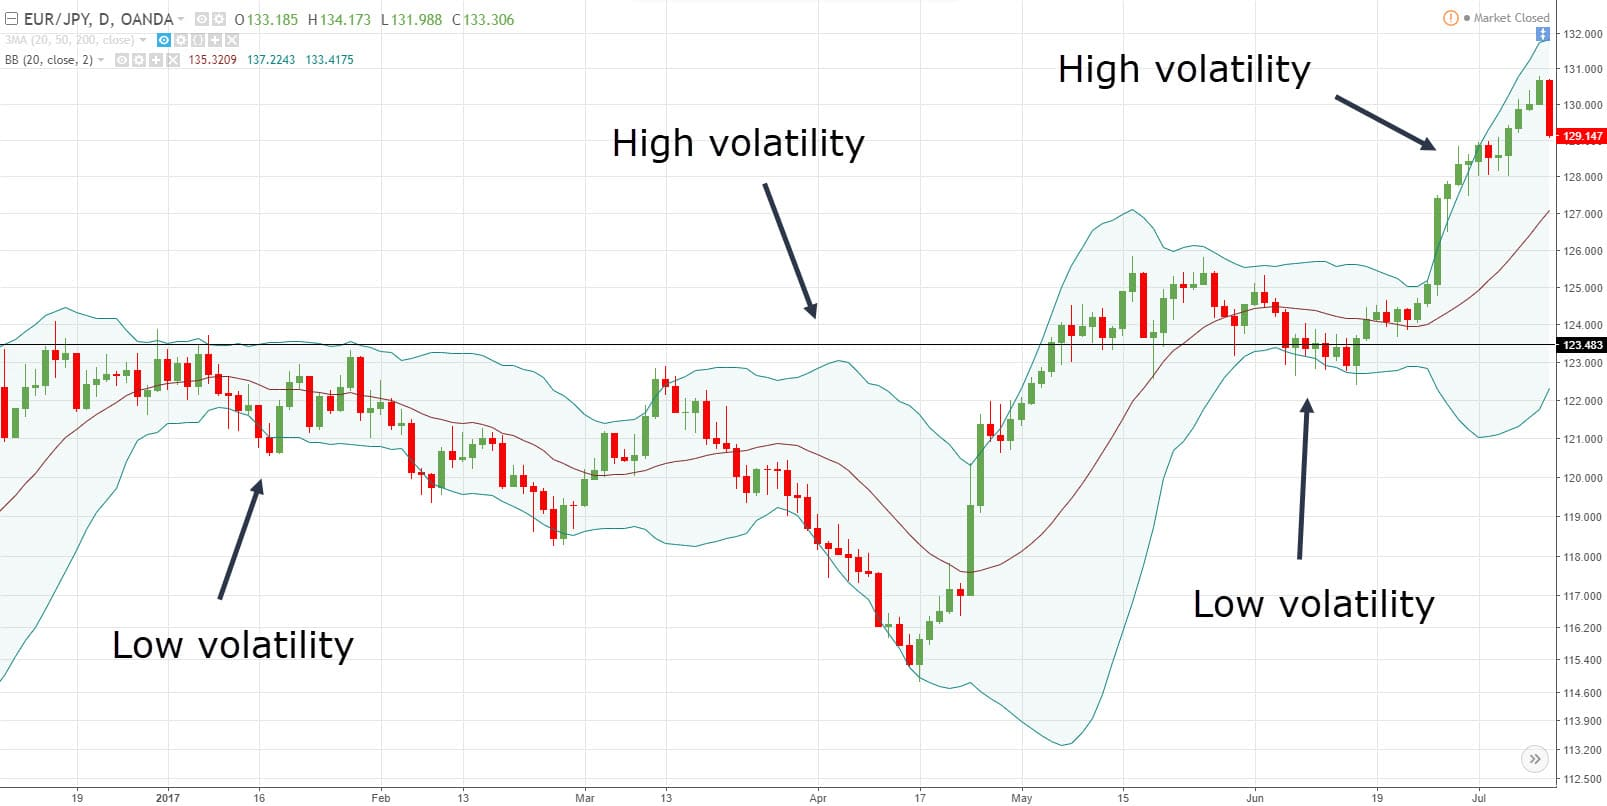

### Now let's begin our implementation.

I will be mainly using the backtrader library from Python, it's a backtesting library for trading strategies.

#### Pulling historical stock price data of Amazon from yahoo finance (Starting 2018).

In [2]:
data = yf.download('AMZN', start = '2018-01-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,58.599998,59.500000,58.525501,59.450500,59.450500,53890000
2018-01-03,59.415001,60.274502,59.415001,60.209999,60.209999,62176000
2018-01-04,60.250000,60.793499,60.233002,60.479500,60.479500,60442000
2018-01-05,60.875500,61.457001,60.500000,61.457001,61.457001,70894000
2018-01-08,61.799999,62.653999,61.601501,62.343498,62.343498,85590000
...,...,...,...,...,...,...
2023-06-06,125.070000,127.400002,125.000000,126.610001,126.610001,45695200
2023-06-07,127.010002,127.370003,120.629997,121.230003,121.230003,95663300
2023-06-08,123.010002,125.629997,122.260002,124.250000,124.250000,62159300


## Trading strategy:
#### Buying conditions: 
If we are not in the market, first check if the stock is above the 200-day moving average and that stock closes 1.8 standard deviation below the 20-day bollinger band.
<br>If both are satisfied, then I will place a 3% buy limit order below the previous day closing price, meaning I will buy for 97% of the current closing price.

#### Selling conditions:
Sell if our RSI is crossing above 50 or after 10 trading days.

(Set a 0.5% buy-in commissions)

In [4]:
# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    #Defining the parameters
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None
        # 200 Day moving Average
        self.sma = bt.ind.SMA(period = 200)
        # Define the pullback: Stock closes 1.8 standard deviation below the 20-day bollinger band
        self.boll = bt.ind.BollingerBands(period = 20, devfactor = 1.8)
        # When to exit 
        # safediv to avoid divide by 0 errors
        self.rsi = bt.ind.RSI(period = 2, safediv = True)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
        
    #Find the strategy
    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            # Check if Stock is above the 200-day moving average
            # Check if stock is below the bollinger band line
            if self.data.close > self.sma and self.data.close < self.boll.lines.bot:

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        # 3% buy limit order
                        self.order = self.buy(exectype = bt.Order.Limit, price = 0.97*self.data.close[0])

        else:

            # Already in the market, sell after 10 trading days or if RSI is greater than 50
            if self.rsi >50 or len(self) >= (self.bar_executed + 10):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [5]:
# Cerebro serves as a central point for gathering all data inputs, execute the backtesting/or live data feeding/trading
# returning the results, and give access to the plotting facilities.
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    # Create a Data Feed
    data = bt.feeds.PandasData(dataname = data)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)
    
    # Set 0.5% buy-in commissions
    cerebro.broker.setcommission(0.005)
    
    # Allow me to put a weight on how much of the 100k I want to use to invest in a single stock. 
    cerebro.addsizer(bt.sizers.PercentSizer, percents = 100)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2018-10-16, Close, 91.00
2018-10-17, Close, 91.59
2018-10-18, Close, 88.54
2018-10-19, Close, 88.20
2018-10-22, Close, 89.46
2018-10-23, Close, 88.43
2018-10-24, Close, 83.21
2018-10-25, Close, 89.11
2018-10-26, Close, 82.14
2018-10-29, Close, 76.94
2018-10-30, Close, 76.52
2018-10-31, Close, 79.90
2018-11-01, Close, 83.28
2018-11-02, Close, 83.28
2018-11-05, Close, 81.39
2018-11-06, Close, 82.14
2018-11-07, Close, 87.77
2018-11-08, Close, 87.75
2018-11-09, Close, 85.62
2018-11-12, Close, 81.84
2018-11-13, Close, 81.56
2018-11-14, Close, 79.95
2018-11-15, Close, 80.97
2018-11-16, Close, 79.67
2018-11-19, Close, 75.61
2018-11-20, Close, 74.77
2018-11-21, Close, 75.84
2018-11-23, Close, 75.10
2018-11-26, Close, 79.07
2018-11-27, Close, 79.07
2018-11-28, Close, 83.89
2018-11-29, Close, 83.68
2018-11-30, Close, 84.51
2018-12-03, Close, 88.62
2018-12-04, Close, 83.42
2018-12-06, Close, 84.96
2018-12-07, Close, 81.46
2018-12-10, Close, 82.05
2018-12-11, Cl

<IPython.core.display.Javascript object>


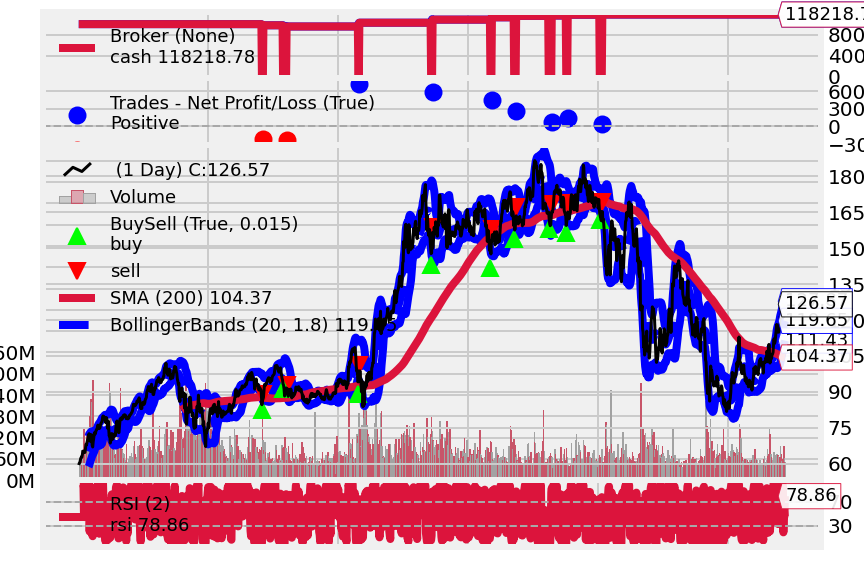

[[<Figure size 432x288 with 5 Axes>]]

In [6]:
%matplotlib inline
cerebro.plot()

## Conclusion:

As we can see, after 5 years of implementing this data starting 2018-01-01, we have made a total of 18218 in profit, approximately an 18% return, which isn't great for 5 years.
<br>In the plot, we can visualize all the necessary details including the SMA trend, the Bollinger Bands, the Equity Curve, the RSI, etc. and understand the logic behind each move.

# Strategy #2: Stochastic Oscillator and MACD

#### We will combine two powerful momentum indicators which are the Stochastic Oscillator and the Moving Average Convergence/Divergence indicator below, aiming to eradicate false signal as much as possible and achieve great returns.

## Stochastic Oscillator

Stochastic oscillator is a momentum-based leading indicator that is commonly used to identify whether the market is in the state of overbought or oversold, namely whether the market's trend seems to be extremely bullish or extremely bearish.
<br> The values of the oscillator lie between 0 and 100 and the general overbought and oversold levels are considered as 70 and 30 respectively.

### The stochastic oscillator comprises of two components:
#### %K Line:
Also known as the Fast Stochastic Indicator, this line's sole purpose is to express the current state of the market(overbought or oversold). It is calculated by substracting the lowest price the stock has reached over a specified number of periods from the closing price of the stock and this difference is divided by the value calculated by substracting the lowest price the stock has reached in this perio from the highest stock price. And the final value is arrived at by multiplying the value calculated from the above-mentioned steps by 100. 14 trading days is the most commonly used periods.

#### %D Line:
Also known as the Slow Stochastic Indicator, this line is the moving average of the %K line for a specified period, with 3 being the standard number of periods.



## Moving Average Convergence/Divergence

Before getting into what MACD is, let me introduce what Exponential Moving Average(EMA) is. EMA is a type of moving average that automatically allocates greater weighting to the most recent data points and lesser weighting to the data points in the past.

Now, MACD is a trend-following leading indicator that is calculated by substracting two EMA(one with longer and the other shorter periods). There are three notable components in a MACD indicator.

#### MACD line: 
This line is the difference between two given EMA, where one EMA has a longer period known as slow length and another EMA with a shorter period known as fast length is calculated. The most popular length is 12, 26 respectively. The final MACD line values can be arrived at by substracting the slow length EMA from the fast length EMA.

#### Signal line: 
This line is the EMA of the MACD line itself for a given period of time. The most popular period to calculate the signal line is 9.

#### Histogram:
It is a histogram purposely plotted to reveal the difference between the MACD line and the Signal line. It is a great component to be used to identify trends.

In [7]:
plt.style.use('ggplot')
%matplotlib inline
# Fetch Amazon's Data
AMZN_data = yf.download('AMZN', '2018-01-01')

[*********************100%***********************]  1 of 1 completed


In [8]:
AMZN_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,58.599998,59.500000,58.525501,59.450500,59.450500,53890000
2018-01-03,59.415001,60.274502,59.415001,60.209999,60.209999,62176000
2018-01-04,60.250000,60.793499,60.233002,60.479500,60.479500,60442000
2018-01-05,60.875500,61.457001,60.500000,61.457001,61.457001,70894000
2018-01-08,61.799999,62.653999,61.601501,62.343498,62.343498,85590000
...,...,...,...,...,...,...
2023-06-06,125.070000,127.400002,125.000000,126.610001,126.610001,45695200
2023-06-07,127.010002,127.370003,120.629997,121.230003,121.230003,95663300
2023-06-08,123.010002,125.629997,122.260002,124.250000,124.250000,62159300


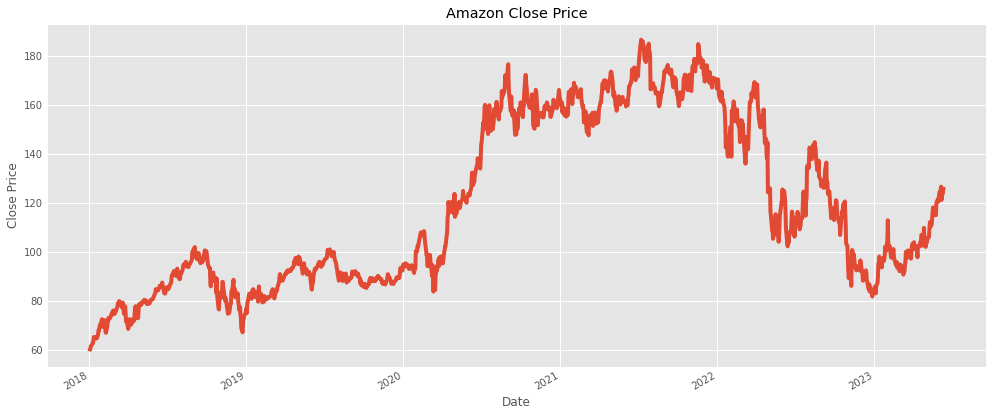

In [9]:
# Visualise the data
AMZN_data['Close'].plot(figsize=(15,7))
plt.ylabel('Close Price')
plt.title('Amazon Close Price')
plt.show()

After visualizing the data, we now get into calculating the stochastic oscillator and the macd.

In [10]:
# STOCHASTIC OSCILLATOR CALCULATION

def get_stoch_osc(high, low, close, k_lookback, d_lookback):
    lowest_low = low.rolling(k_lookback).min()
    highest_high = high.rolling(k_lookback).max()
    k_line = ((close - lowest_low) / (highest_high - lowest_low)) * 100
    d_line = k_line.rolling(d_lookback).mean()
    return k_line, d_line

AMZN_data['%k'], AMZN_data['%d'] = get_stoch_osc(AMZN_data['High'], AMZN_data['Low'], AMZN_data['Close'], 14, 3)
AMZN_data

,Open,High,Low,Close,Adj Close,Volume,%k,%d
Date,,,,,,,,
2018-01-02,58.599998,59.500000,58.525501,59.450500,59.450500,53890000,NaN,NaN
2018-01-03,59.415001,60.274502,59.415001,60.209999,60.209999,62176000,NaN,NaN
2018-01-04,60.250000,60.793499,60.233002,60.479500,60.479500,60442000,NaN,NaN
2018-01-05,60.875500,61.457001,60.500000,61.457001,61.457001,70894000,NaN,NaN
2018-01-08,61.799999,62.653999,61.601501,62.343498,62.343498,85590000,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-06-06,125.070000,127.400002,125.000000,126.610001,126.610001,45695200,94.199701,91.536235
2023-06-07,127.010002,127.370003,120.629997,121.230003,121.230003,95663300,54.698995,80.597704
2023-06-08,123.010002,125.629997,122.260002,124.250000,124.250000,62159300,76.872240,75.256979


In the calculation above, we first calculated the lowest low and the highest high data points for a specified number of periods using the "rolling", "min", and "max" functions from Pandas. Then we calculated the %K line following the formula mentioned previously, then take the SMA of the %K line for a specified number of periods to get %D line. In our case, we use 14 and 3 as the lookback periods of the %K and %D line.

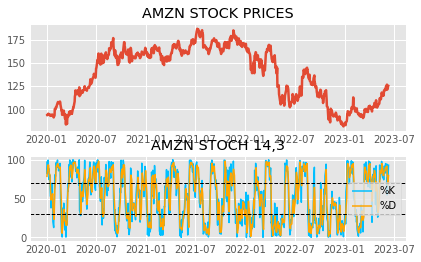

In [11]:
# STOCHASTIC OSCILLATOR PLOT

plot_data = AMZN_data[AMZN_data.index >= '2020-01-01']

ax1 = plt.subplot2grid((14,1), (0,0), rowspan = 7, colspan = 1)
ax2 = plt.subplot2grid((15,1), (9,0), rowspan = 6, colspan = 1)
ax1.plot(plot_data['Close'], linewidth = 2.5)
ax1.set_title('AMZN STOCK PRICES')
ax2.plot(plot_data['%k'], color = 'deepskyblue', linewidth = 1.5, label = '%K')
ax2.plot(plot_data['%d'], color = 'orange', linewidth = 1.5, label = '%D')
ax2.axhline(70, color = 'black', linewidth = 1, linestyle = '--')
ax2.axhline(30, color = 'black', linewidth = 1, linestyle = '--')
ax2.set_title(f'AMZN STOCH 14,3')
ax2.legend(loc = 'right')
plt.show()

In [12]:
# MACD CALCULATION

def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'Close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    return macd, signal, hist

AMZN_data['macd'] = get_macd(AMZN_data['Close'], 26, 12, 9)[0]
AMZN_data['macd_signal'] = get_macd(AMZN_data['Close'], 26, 12, 9)[1]
AMZN_data['macd_hist'] = get_macd(AMZN_data['Close'], 26, 12, 9)[2]
AMZN_data = AMZN_data.dropna()
AMZN_data

,Open,High,Low,Close,Adj Close,Volume,%k,%d,macd,macd_signal,macd_hist
Date,,,,,,,,,,,
2018-01-24,68.740997,69.407997,66.900002,67.875504,67.875504,136150000,83.297064,91.502086,1.926637,1.411475,0.515162
2018-01-25,68.400002,68.917000,67.880997,68.897499,68.897499,95060000,94.269216,92.076628,2.093057,1.547791,0.545265
2018-01-26,69.600502,70.126503,69.045502,70.102501,70.102501,97146000,99.718451,92.428244,2.295716,1.697376,0.598340
2018-01-29,70.459000,71.569504,70.022003,70.884003,70.884003,114038000,92.938805,95.642157,2.490674,1.856036,0.634639
2018-01-30,70.158501,71.962502,69.599998,71.890999,71.890999,117438000,99.292123,97.316460,2.695366,2.023902,0.671464
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-06,125.070000,127.400002,125.000000,126.610001,126.610001,45695200,94.199701,91.536235,4.947614,4.224192,0.723422
2023-06-07,127.010002,127.370003,120.629997,121.230003,121.230003,95663300,54.698995,80.597704,4.630537,4.305461,0.325075
2023-06-08,123.010002,125.629997,122.260002,124.250000,124.250000,62159300,76.872240,75.256979,4.570256,4.358420,0.211836


In the code cell above, we first calculated the fast and slow length EMAs using the "ewm" function. Next we calculated the values of the MACD line by substracting the slow length EMA from the fast length EMA. Followed by that, we defined a variable named "signal" to store the values of the Signal line calculated by taking the EMA of the MACD line's values for a specified number of periods. Then, we calculated the histogram values by substracting the MACD line's values from the Signal line's values.

#### As I stated previously, we used 26, 12, and 9 as the periods for the two EMA and the signal line calculation.

## Let's define our trading strategy
### Buying Condition
If %K line and %D line both go below 30 and the MACD and Signal lines are less than -2, we go long since these signals means that the stock may be oversold and has the potential for a price bounce.
### Selling Condition
If %K Line and %D line crosses above 70, and both the components of the MACD indicator are greater than 2, then we go short. We suspect there may be an overbought of stock and the stock may be trading at a level above its intrinsic value.

In [13]:
def macd_strategy(prices, k, d, macd, macd_signal):    
    buy_price = []
    sell_price = []
    stoch_macd = []
    signal = 0

    for i in range(len(prices)):
        if k[i] < 30 and d[i] < 30 and macd[i] < -2 and macd_signal[i] < -2:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                stoch_macd.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_macd.append(0)
                
        elif k[i] > 70 and d[i] > 70 and macd[i] > 2 and macd_signal[i] > 2:
            if signal != -1 and signal != 0:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                stoch_macd.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_macd.append(0)
        
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            stoch_macd.append(0)
            
    return buy_price, sell_price, stoch_macd
            
buy_price, sell_price, stoch_macd = macd_strategy(AMZN_data['Close'], AMZN_data['%k'], AMZN_data['%d'], AMZN_data['macd'], AMZN_data['macd_signal'])

We are implementing the trading strategy through a for-loop. Inside the for-loop, we pass certain conditions I mentioned previously, and if the conditions are satisfied, the respective values will be appended to the empty lists. If the condition to buy the stock gets satisfied, the buying price will be appended to the "buy_price" list and the signal value will be appended as 1 representing to buy the stock. Similarly, if condition to sell are satisfied, the selling price will be appended to the "sell_price" list and the signal value will be -1.

In [14]:
# POSITION

position = []
for i in range(len(stoch_macd)):
    if stoch_macd[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(AMZN_data['Close'])):
    if stoch_macd[i] == 1:
        position[i] = 1
    elif stoch_macd[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
close_price = AMZN_data['Close']
k_line = AMZN_data['%k']
d_line = AMZN_data['%d']
macd_line = AMZN_data['macd']
signal_line = AMZN_data['macd_signal']
stoch_macd_signal = pd.DataFrame(stoch_macd).rename(columns = {0:'stoch_macd_signal'}).set_index(AMZN_data.index)
position = pd.DataFrame(position).rename(columns = {0:'stoch_macd_position'}).set_index(AMZN_data.index)

frames = [close_price, k_line, d_line, macd_line, signal_line, stoch_macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy


,Close,%k,%d,macd,macd_signal,stoch_macd_signal,stoch_macd_position
Date,,,,,,,
2018-01-24,67.875504,83.297064,91.502086,1.926637,1.411475,0,1
2018-01-25,68.897499,94.269216,92.076628,2.093057,1.547791,0,1
2018-01-26,70.102501,99.718451,92.428244,2.295716,1.697376,0,1
2018-01-29,70.884003,92.938805,95.642157,2.490674,1.856036,0,1
2018-01-30,71.890999,99.292123,97.316460,2.695366,2.023902,0,1
...,...,...,...,...,...,...,...
2023-06-06,126.610001,94.199701,91.536235,4.947614,4.224192,0,0
2023-06-07,121.230003,54.698995,80.597704,4.630537,4.305461,0,0
2023-06-08,124.250000,76.872240,75.256979,4.570256,4.358420,0,0


In the code cell above, we first create an empty list named position and pass two for-loops, one to generate values for the "position" list to match the length of the "signal" list. The other for-loop is the one we use to generate actual position values. In this "other" for-loop, we iterate over the values of the "signal" list and the values of the position list get appended depends on which condition are satisfied. The value of the position remains 1 if we hold the stock, or remains 0 if we sold or don't own the stock.

### Backtesting

In [15]:
# BACKTESTING

AMZN_backtest = pd.DataFrame(np.diff(AMZN_data['Close'])).rename(columns = {0:'returns'})
stoch_macd_strategy_return = []

for i in range(len(AMZN_backtest)):
    try:
        returns = AMZN_backtest['returns'][i] * strategy['stoch_macd_position'][i]
        stoch_macd_strategy_return.append(returns)
    except:
        pass
    
stoch_macd_strategy_return_df = pd.DataFrame(stoch_macd_strategy_return).rename(columns = {0:'stoch_macd_returns'})

investment_value = 100000
number_of_stocks = floor(investment_value / AMZN_data['Close'][0])
stoch_macd_investment_return = []

for i in range(len(stoch_macd_strategy_return_df['stoch_macd_returns'])):
    returns = number_of_stocks * stoch_macd_strategy_return_df['stoch_macd_returns'][i]
    stoch_macd_investment_return.append(returns)

stoch_macd_investment_return_df = pd.DataFrame(stoch_macd_investment_return).rename(columns = {0:'investment_returns'})
total_investment_return = round(sum(stoch_macd_investment_return_df['investment_returns']), 2)
print(cl('Profit gained from the STOCH MACD strategy by investing $100k in Amazon : {}'.format(total_investment_return), attrs = ['bold']))

Profit gained from the STOCH MACD strategy by investing $100k in Amazon : 111120.89


#### Similar to the Bollinger Bands strategy, we will backtest our second strategy by investing 100k in Amazon using the data starting from 2018 and we find ourselves profiting approximately 111% over a span of 5 years following the stochastic oscillator and MACD strategy, doing signifcantly better than our first strategy.

### SPY ETF Comparison. 

In the step below, we follow similar logic but use the SPY ETF data to compare the returns we get from the SPY ETF with our two trading strategy returns on Amazon.

In [16]:
def get_benchmark(start_date, investment_value):
    spy = yf.download('SPY', start_date)['Close']
    benchmark = pd.DataFrame(np.diff(spy)).rename(columns = {0:'benchmark_returns'})
    
    investment_value = investment_value
    number_of_stocks = floor(investment_value/spy[0])
    benchmark_investment_ret = []
    
    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

benchmark = get_benchmark('2018-01-01', 100000)

investment_value = 100000
total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)
benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
print(cl('Benchmark profit by investing $100k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))

[*********************100%***********************]  1 of 1 completed
Benchmark profit by investing $100k : 61391.16


#### From above, we see that while SPY ETF profitted around 61%, significantly better than our bollinger band trading strategy, our Stochastic Oscillator and MACD strategy ultimately outperformed the benchmark by over 50%.